# Import packages

The following methods describe the functions used to produce results with Stone methodology applied to a metacommunity matrix. Each chapter of the thesis will have its own modified version of this code. 

In [1]:
# import packages
import numpy as np
import random 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.integrate import odeint


## Function to vizualize matrix

This function prodives an interactive way to vizualize matrices and the numbers in each row and column. The colorscale might need to be modified depending the range of numbers in the matrix. Specially when there are big differences between minimum numbers and the maximum numbers in $$A_{ij}$$

In [2]:
def plot_matrix(matrix, title="Matrix with Regular Color Scale", use_meta=False):
    """
    Normalize each row of a given matrix and plot a heatmap with a color scale.
    If 'meta' is present in the title, a custom red-to-green color scale is used; 
    otherwise, a regular color scale is used.
    
    Args:
        matrix (numpy.ndarray): Input 2D matrix.
        title (str): Title of the heatmap (used to decide the color scale).
        use_meta (bool): Flag to apply the custom color scale when True, 
                         or use a regular color scale otherwise.
    """
    # Normalize the matrix
    norm_conf = []
    for row in matrix:
        row_sum = sum(row)
        normalized_row = [float(val) / float(row_sum) if row_sum != 0 else 0 for val in row]
        norm_conf.append(normalized_row)
    normalized_matrix = np.array(norm_conf)
    
    # Define custom color scale (red-to-green)
    custom_colorscale = [
        [0, 'darkred'],   # Dark red for negative values
        [0.4999, 'red'],  # Red for negative values
        [0.5, 'white'],   # White for zero values
        [0.511111111, 'blue'],  # Green for positive values
        [1, 'darkblue']  # Dark green for positive values
    ]
    
    # Define regular color scale (default)
    regular_colorscale = 'Viridis'  # You can use any built-in color scale, e.g., 'Viridis', 'Cividis', etc.
    
    # Select color scale based on the flag or title
    colorscale = custom_colorscale if use_meta or 'meta' in title.lower() else regular_colorscale
    
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=matrix,  # Use the original matrix
        x=np.arange(1, matrix.shape[1] + 1),
        y=np.arange(1, matrix.shape[0] + 1),  # Reverse the y-axis labels
        colorscale=colorscale,
        zmid=0,  # Set the midpoint of the color scale to zero
    ))
    
    # Update layout for better visualization
    fig.update_layout(
        yaxis=dict(autorange='reversed'),
        title=title,
        xaxis_title='Column',
        yaxis_title='Row',
    )
    
    # Show the plot
    fig.show()
    
    return #normalized_matrix  # Return the normalized matrix

## Function to sample local communities

### Parameters

S= Number of Species

C=Connectivity

$\sigma$= Standard deviation of interaction strength 

Pm= proportion of mutualistic interaction (+/+)

Pc=proportion of competitive interaction (-/-)

Pe= proportion of exploitative interaction (+/-)

We will create matrix **A**, with dimensions *S* * *S*. The matrix **A** will contain all the interactions between species. The effect of species _i_ on species _j_ is will be on the off diagonal. The diagonal of matrix __A__ will be set to -s. The matrix __A__ elements will be the following:

$$a_{ij}= N(0,\sigma)$$
$$a_{ii}=-s$$

Refrences

Coyte, K. Z., Schluter, J., & Foster, K. R. (2015).Science, 350(6261), 663–666. http://doi.org/10.1126/science.aad2602

May, R. M. (1972). Will a large complex system be stable? Nature, 238(5364), 413–414.

In [3]:
def local_matrix_A (matrix_para):
    
    #pull the values from the list matrix_para
    
    S=matrix_para['S']
    C = matrix_para['C']
    sigma = matrix_para['sigma']
    Pm = matrix_para['Pm']
    Pc = matrix_para['Pc']
    Pe= matrix_para['Pe']
    s = matrix_para['s']
    
    # Ensure that the sum of Pm, Pe, and Pc is equal to 1
    if not np.isclose(Pm + Pe + Pc, 1.0):
        raise ValueError("The sum of Pm, Pe, and Pc must be equal to 1.")
    
    A= np.zeros((S,S))
    
    np.fill_diagonal (A,-s)
    
    #loop to assign values to a_ij and a_ii
    
    for i in range(1,S):
        for j in range(i):
            if np.random.rand()<= C:
                
                #Assign the random variable
                p = np.random.rand()
                a = sigma*abs(np.random.normal(0,1))
                b = sigma*abs(np.random.normal(0,1))
                
                if p > 1-Pm: #assign mutualism
                    A[i,j]= a
                    A[j,i]= b
                    
                elif p<= Pc: #assign competition
                    A[i,j]= -a
                    A[j,i]= -b
                    
                elif Pc<p<=1-Pm: #assign exploitative
                    if np.random.rand()<= 0.5:
                        A[i,j]= a
                        A[j,i]=-b
                    else:
                        A[i,j]= -a
                        A[j,i]= b
    return A
            

In [4]:
#parameters
S=10
C=0.5
sigma= 0.5
Pc=0
Pm=1
Pe=0
s= 1

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}
matrix_para

A=local_matrix_A(matrix_para)
plot_matrix(A)

## Function to sample Local communities into a metacommunity

This function will call the function __local matrix A__ to corresponding to the number of local communities within the metacommunity. The parameter _L_, represents the number of local communities in the system. This code also has built in modifications, so we can explore the stability of universal matrices.

L= number of local communities in the metacommunity


B= Base matrix used to sample other communities if delta is present. This base matrix will be multiply by __V__ matrix, with entries $V_{ij}=U(1-\delta, 1 + \delta)$

$\delta$= measure of universality between the local communities in the metacommunity. If delta is not present, each of the local communities in the metacommunity will be independenly sampled. The delta value will not be greater than 1 due to possible modification to the signs of the base matrix.



In [5]:
# This version only works in single communities
def collection_local_matrices(L, matrix_para):
    
    S = matrix_para['S']
    C = matrix_para['C']
    sigma = matrix_para['sigma']
    Pm = matrix_para['Pm']
    Pc = matrix_para['Pc']
    Pe=matrix_para['Pe']
    s = matrix_para['s']
    
    A = np.empty((S, S, L))
    
    if matrix_para.get('delta') is None:
        for i in range(L):
            A[:, :, i] = local_matrix_A(matrix_para)
    else:
        delta = matrix_para['delta']
        B = local_matrix_A(matrix_para)

        for i in range(L):
            U = np.random.uniform(1 - delta, 1 + delta, (S, S))
            thisA = U * B
            np.fill_diagonal(thisA, -s)
            A[:, :, i] = thisA

    return A
L=2
A=collection_local_matrices(L,matrix_para)

## Function to Arrange values of A into a metacommunity matrix __J__

In [6]:
import numpy as np  # Ensure you have numpy imported

def subcommunity_mask(a, b, S, M):
    """
    Return a mask of the metacommunity matrix
    corresponding to interactions between taxa
    in subcommunities a and b.
    """
    rows = slice((a - 1) * S, a * S)
    cols = slice((b - 1) * S, b * S)
    
    mask = np.zeros((S * M, S * M), dtype=bool)
    mask[rows, cols] = True  # This line is correct as it sets the specified block to True
    
    return mask

def meta_A(L, S, matrix_para):
    """
    This is representative of the A matrix found in the jacobian J
    """
    AA = collection_local_matrices(L, matrix_para)
    
    # Assemble the metacommunity interaction matrix A
    A = np.zeros((S * L, S * L))
    
    # Place interaction matrices along the block diagonal
    for i in range(1, L + 1):
        row_start = (i - 1) * S
        row_end = i * S
        col_start = (i - 1) * S
        col_end = i * S
        
        A[row_start:row_end, col_start:col_end] = AA[:, :, i - 1]
    
    return A

## Function to generate matrix __G__ containing the dispersal of the local communities

In [7]:
import numpy as np

def get_mij(L, S, m):
    """
    Assemble metacommunity immigration matrix (off diagonal) 
    """
    m_ij = np.zeros((S * L, S * L))
    
    row_taxa = np.tile(np.arange(S), (L * S, 1))
    col_taxa = row_taxa.T
    
    x = np.repeat(np.arange(L), S)
    row_subcom = np.tile(x, (L * S, 1))
    col_subcom = row_subcom.T
    
    for i in range(S * L):
        for j in range(S * L):
            is_different_subcom = row_subcom[i, j] != col_subcom[i, j]
            is_same_taxa = row_taxa[i % S, j % S] == col_taxa[i % S, j % S]
            is_disperal = is_different_subcom and is_same_taxa
            
            if is_disperal:
                m_ij[i, j] = m / (L - 1)
    
    return m_ij

# Example usage
L=3
m=4
S=4
m_ij=get_mij(L,S,m)
plot_matrix(m_ij)

## Function to Calculate the $N_i^*$ in order to impose feasibility

All the $N_i^*$ will be arranged in a diagonal matrix __D__. For our perspective to in metacommunity matrix, we need to complete the construction of the metacommunity in order tocalculate its $N_i^*$

In [8]:
def f(N, m, m_ij):
    """
    Calculate the function f. This function is our approximation as migration increases
    """
    return -m + (1 / N) * (m_ij @ N)

def find_feasible_equilibrium(A, r, m, m_ij):
    """
    Find feasible equilibrium N^*.
    """
    Ainv = np.linalg.inv(A)
    Nstar_nomigration = -Ainv @ r
    Approximation = f(Nstar_nomigration, m, m_ij)
    
    Nhatstar = -Ainv @ (Approximation + r)
    
    return Nhatstar

#Example of usage
L=3
S=2
m=1
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
Nhatstar

array([1.39219413, 1.39794175, 5.92153185, 5.49124292, 5.67920744,
       6.16530609])

In [9]:
# Define the GLV system for a metacommmunity
def glv_system(t, x, r, a, m, m_ij):
    """
    Generalized Lotka-Volterra system.
    
    Parameters:
    - t: Time
    - x: Array of population densities 
    - r: Intrinsic growth rates (array)
    - a: Interaction matrix (2D array, n x n)
    - m: Emigration rates
    - m_ij: immigration rates 
    
    Returns:
    - dx/dt: Time derivative of x
    """
    dxdt = x * (r + np.dot(a, x)) - m * x + np.dot(m_ij, x)
    return dxdt

In [10]:
# Define example parameters
L = 2
S = 100
C = 0.7
sigma = 0.02
Pc = 0.5
Pm = 0.25
Pe = 0.25
s = 1

m = 0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)


# Get Nhatstar for these parameters
Nhatstar = find_feasible_equilibrium(A, r, m, m_ij)

# Initial conditions
x0 = Nhatstar

# Test GLV function
#out = glv_system(0, x0, r, A, m, m_ij)

Nhatstar

array([0.74751658, 0.8033312 , 0.61306125, 0.56439767, 0.92069197,
       0.97450621, 0.65728875, 0.86971262, 0.81262305, 0.5720339 ,
       0.77621689, 0.96021749, 0.85352387, 0.79009394, 0.81253672,
       0.71166159, 0.60851957, 0.76588818, 1.07687818, 0.95236744,
       0.66540192, 0.7784347 , 0.88859432, 0.80043175, 1.07895418,
       0.85642339, 0.6278559 , 1.06134145, 0.72277071, 0.73635829,
       0.73975238, 0.62686905, 0.72352773, 0.72808258, 0.6622856 ,
       0.77330562, 0.69239978, 0.81628889, 0.94098079, 0.72805901,
       0.57926038, 0.76999774, 0.78252894, 0.74076166, 0.93297187,
       0.83075064, 0.76401   , 0.78715595, 0.8240713 , 0.69635649,
       1.02764921, 0.87745318, 0.97385338, 0.70804953, 0.81617142,
       0.91078116, 0.9685342 , 0.64482588, 0.58130374, 0.6655193 ,
       0.87252398, 0.86684432, 0.75375831, 0.51105619, 0.82195339,
       0.90426934, 0.86919585, 0.77411618, 0.81385061, 0.76973083,
       1.09577256, 1.06001631, 0.6929922 , 0.70993424, 0.60164

In [11]:
# function for replacing negative values with 1 in Nhatstar

def replace_negative_values_with_ones(Nhatstar):
    """
    Replace negative values in Nhatstar with 1.
    """
    Nhatstar[Nhatstar <0] = 1
    return Nhatstar

# Example usage
Nhatstar = replace_negative_values_with_ones(Nhatstar)
Nhatstar

# Initial conditions
x0 = Nhatstar
x0


array([0.74751658, 0.8033312 , 0.61306125, 0.56439767, 0.92069197,
       0.97450621, 0.65728875, 0.86971262, 0.81262305, 0.5720339 ,
       0.77621689, 0.96021749, 0.85352387, 0.79009394, 0.81253672,
       0.71166159, 0.60851957, 0.76588818, 1.07687818, 0.95236744,
       0.66540192, 0.7784347 , 0.88859432, 0.80043175, 1.07895418,
       0.85642339, 0.6278559 , 1.06134145, 0.72277071, 0.73635829,
       0.73975238, 0.62686905, 0.72352773, 0.72808258, 0.6622856 ,
       0.77330562, 0.69239978, 0.81628889, 0.94098079, 0.72805901,
       0.57926038, 0.76999774, 0.78252894, 0.74076166, 0.93297187,
       0.83075064, 0.76401   , 0.78715595, 0.8240713 , 0.69635649,
       1.02764921, 0.87745318, 0.97385338, 0.70804953, 0.81617142,
       0.91078116, 0.9685342 , 0.64482588, 0.58130374, 0.6655193 ,
       0.87252398, 0.86684432, 0.75375831, 0.51105619, 0.82195339,
       0.90426934, 0.86919585, 0.77411618, 0.81385061, 0.76973083,
       1.09577256, 1.06001631, 0.6929922 , 0.70993424, 0.60164

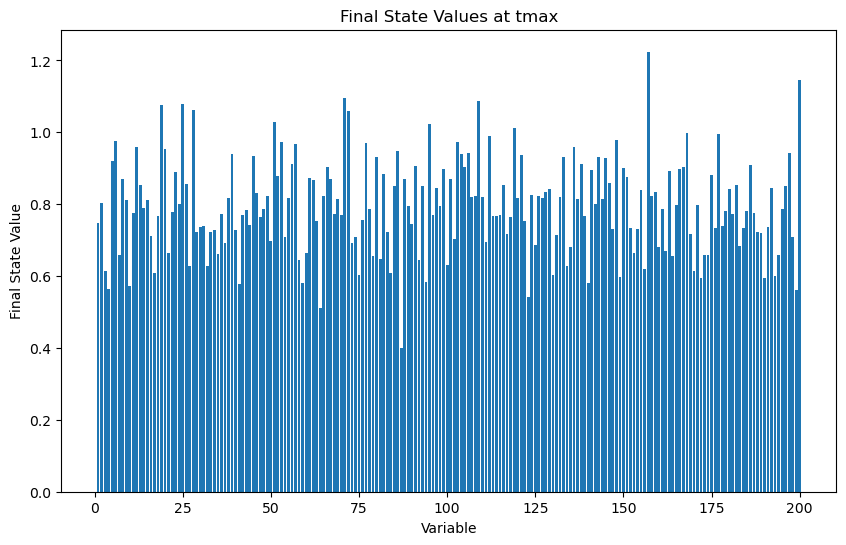

In [12]:
# Numerically integrate the GLV system to find equilibria

from scipy.integrate import solve_ivp

def simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10, 
                        full_output=False):
    """
    Simulates the generalized Lotka-Volterra (GLV) system and returns the final state variables at tmax.

    Parameters:
    glv_system (function): The GLV system function to integrate.
    x0 (array-like): Initial conditions for the state variables.
    r (array-like): Growth rates.
    A (array-like): Interaction matrix.
    m (array-like): Mortality rates.
    m_ij (array-like): Additional interaction parameters.
    tmax (float): Time by which equilibrium is assumed to be reached (default is 10).

    Returns:
    np.ndarray: Final values of the state variables at tmax.
    """
    t_span = (0, tmax)  # Time range for the simulation
    t_eval = np.linspace(t_span[0], t_span[1], 100)  # Evaluation points
    
    # Solve the system
    sol = solve_ivp(
        glv_system, t_span, x0, args=(r, A, m, m_ij), t_eval=t_eval, method='RK45'
    )
    
    # Return the final state variables at tmax
    if full_output:
        return sol
    else:
        return sol.y[:, -1]


Nstar = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10)
#print("Final state values at tmax:")
#for i, value in enumerate(Nstar, start=1):
#    print(f"Variable {i}: {value:.4f}")

# Plotting Nstar as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(Nstar) + 1), Nstar)
plt.xlabel('Variable')
plt.ylabel('Final State Value')
plt.title('Final State Values at tmax')
plt.show()

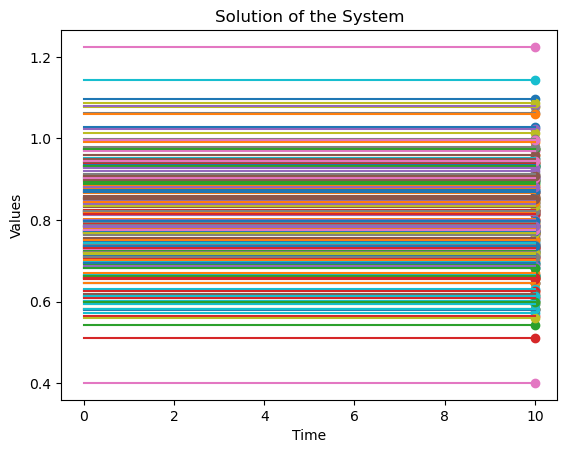

In [13]:
# Plot output
sol = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10, full_output=True)
Nstar = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10)
for i in range(sol.y.shape[0]):  # Loop over each variable
    plt.plot(sol.t, sol.y[i], label=f"Variable {i+1}")
    
for i, Nstari in enumerate(Nstar):
    plt.scatter(sol.t[-1], Nstari, label=f"Final Value (Variable {i+1})", marker='o')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System')
#plt.legend()
plt.show()

In [14]:
print(sol.status)
print(sol.message)

0
The solver successfully reached the end of the integration interval.


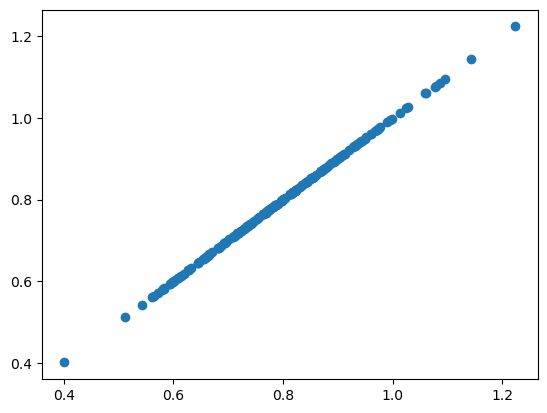

In [15]:
plt.scatter(Nhatstar,Nstar)

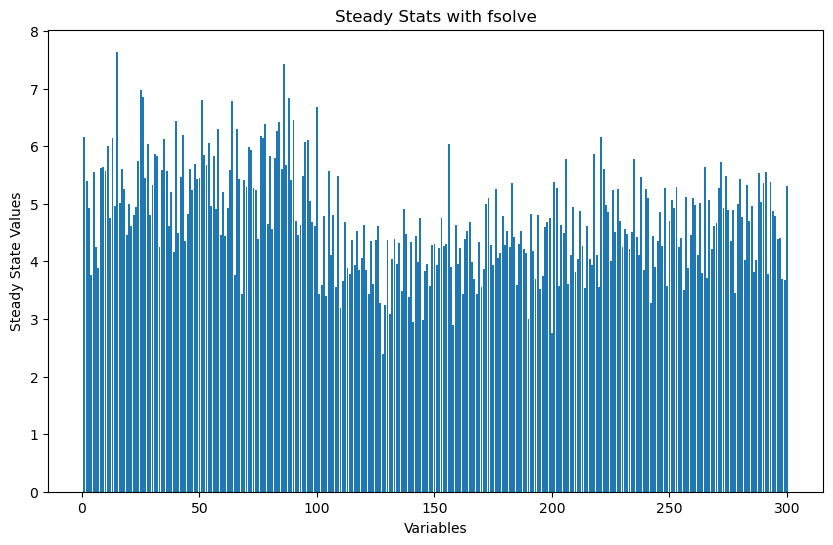

In [39]:
# Simulate steady state of GLV through fsolve(by solving for the roots)
from scipy.optimize import fsolve

def glv_system1(x, r, A, m, m_ij):
    dxdt = x * (r + np.dot(A, x)) - m * x + np.dot(m_ij, x)
    return dxdt


def steady_fsol(glv_system1, x0, r, A, m, m_ij):
    """
    Finds the steady state of the generalized Lotka-Volterra (GLV) system.

    Parameters:
    glv_system (function): The GLV system function.
    x0 (array-like): Initial guess for the state variables.
    r (array-like): Growth rates.
    A (array-like): Interaction matrix.
    m (array-like): Mortality rates.
    m_ij (array-like): Additional interaction parameters.

    Returns:
    np.ndarray: Steady state values of the state variables.
    """
    steady_state = fsolve(glv_system1, x0, args=(r, A, m, m_ij))
    return steady_state

# Example usage
L = 3
S = 100
C = 0.7
sigma = 0.02
Pc = 0.1
Pm = 0.8
Pe = 0.1
s = 1

m = 0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

#Sample Nhatstar
Nhatstar = find_feasible_equilibrium(A, r, m, m_ij)
Nhatstar = replace_negative_values_with_ones(Nhatstar)

# Initial conditions
x0 = Nhatstar
steady_state = steady_fsol(glv_system1, x0, r, A, m, m_ij)
#print("Steady state values:")
#for i, value in enumerate(steady_state, start=1):
#    print(f"Variable {i}: {value:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(steady_state) + 1), steady_state)
plt.xlabel('Variables')
plt.ylabel('Steady State Values')
plt.title('Steady Stats with fsolve')
#plt.grid(True)
plt.show()

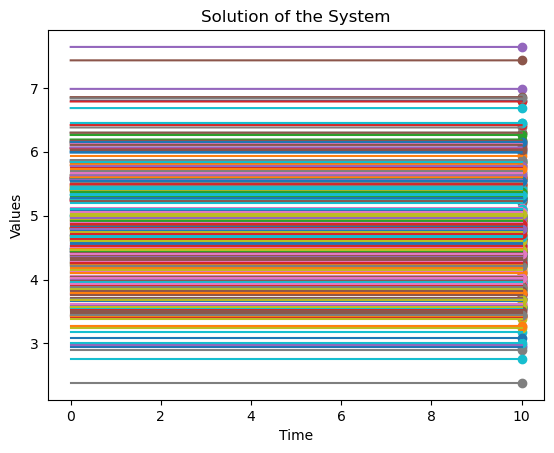

In [40]:
# Check whether it looks like fsolve correctly found the steady state (if system is feasible)
sol = simulate_glv_system(glv_system, x0, r, A, m, m_ij, tmax=10, full_output=True)
for i in range(sol.y.shape[0]):  # Loop over each variable
    plt.plot(sol.t, sol.y[i], label=f"Variable {i+1}")
    
for i, steady_state_i in enumerate(steady_state):
    plt.scatter(sol.t[-1], steady_state_i, label=f"Final Value (Variable {i+1})", marker='o')

plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System')
#plt.legend()
plt.show()

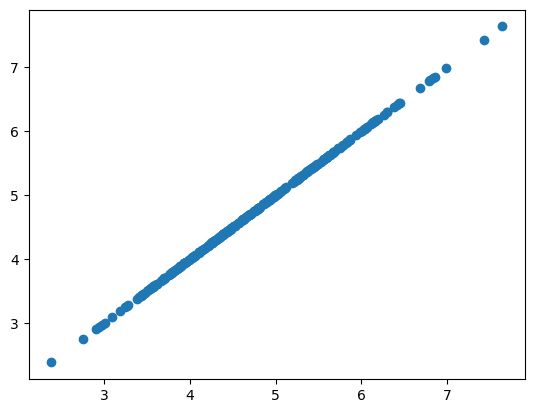

In [41]:
plt.scatter(Nhatstar,steady_state)

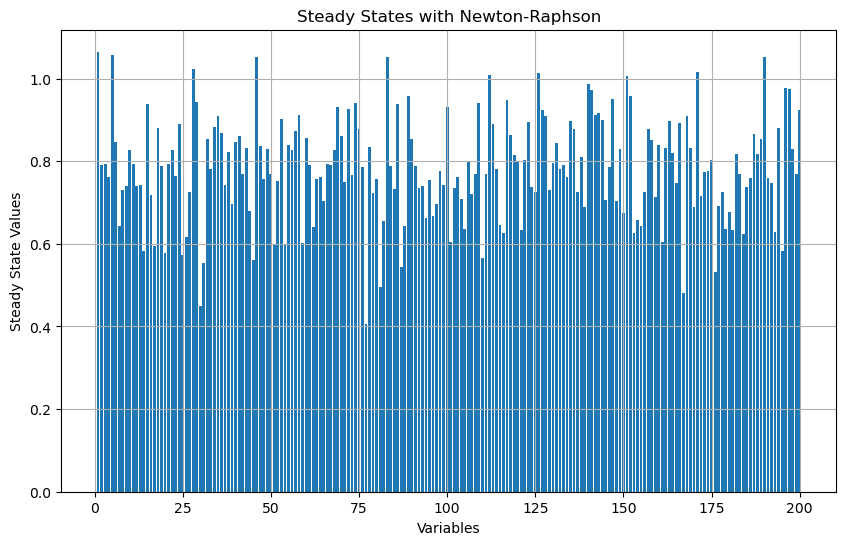

In [19]:
from scipy.optimize import root
def glv_system2(x, r, A, m, m_ij):
    dxdt = x * (r + np.dot(A, x)) - m * x + np.dot(m_ij, x)
    return dxdt

def steady_NR(glv_system2, x0, r, A, m, m_ij):
    """
    Finds the steady state of the generalized Lotka-Volterra (GLV) system using the Newton-Raphson method.

    Parameters:
    glv_system (function): The GLV system function.
    x0 (array-like): Initial guess for the state variables.
    r (array-like): Growth rates.
    A (array-like): Interaction matrix.
    m (array-like): Mortality rates.
    m_ij (array-like): Additional interaction parameters.

    Returns:
    np.ndarray: Steady state values of the state variables.
    """
    sol = root(glv_system2, x0, args=(r, A, m, m_ij), method='hybr')
    return sol.x

#Example of usage
# Example usage
L = 2
S = 100
C = 0.7
sigma = 0.02
Pc = 0.5
Pm = 0.25
Pe = 0.25
s = 1

m = 0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

# Get Nhatstar for these parameters
Nhatstar = find_feasible_equilibrium(A, r, m, m_ij)
Nhatstar = replace_negative_values_with_ones(Nhatstar)

# Initial conditions
x0 = Nhatstar

steady_state = steady_NR(glv_system2, x0, r, A, m, m_ij)
#print("Steady state values:")
#or i, value in enumerate(steady_state, start=1):
#    print(f"Variable {i}: {value:.4f}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(steady_state) + 1), steady_state)
plt.xlabel('Variables')
plt.ylabel('Steady State Values')
plt.title('Steady States with Newton-Raphson')
plt.grid(True)
plt.show()

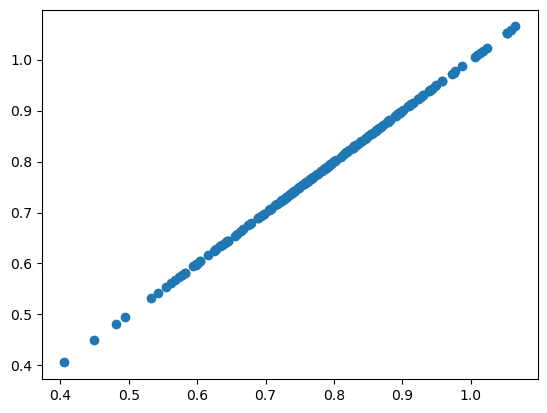

In [20]:
plt.scatter(Nhatstar,steady_state)

## Function to set the Jacobian matrix J

$$ J=D*A+G$$

__D__ is a diagonal matrix with the approximation of population equilibria of all the species in the systems  $D= \hat{N_i}^*$ 

__A__ is the interaction matrix, effects of species _j_ on species _i_

__G__ is the dispersal matrix with entries describing the dispersal of species between local communities

In [ ]:
#function to compute the Jacobian
def Compute_J(A, Nstar, m_ij):
    """
    This is Stone version of the J metacommunity matrix
    """
    #Assemble G matrix (dispersal)
    G = np.zeros_like(A)
    np.fill_diagonal(G, -1 / Nstar * (m_ij @ Nstar))  #1/Nstar is problematic when the value is 0
    G += m_ij
    
    #Assemble D matrix containing the N_i* for all the species in the system
    D = np.diag(Nstar)
    
    #Assemble Stability Matrix like Roberts and Stone
    S=D@A
    #Assemble Jacobian
    J= S +G
    
    return J


In [ ]:

#Example of usage
#parameters
L=3
S=100
C=0.7
sigma= 0.02
Pc=0
Pm=0.5
Pe=0.5
s= 1

m=3
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

A=meta_A(L,S,matrix_para)
m_ij=get_mij(L,S,m)

Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
Nhatstar = replace_negative_values_with_ones(Nhatstar)
#Nstar = simulate_glv_system(glv_system, Nhatstar, r, A, m, m_ij, tmax=10)
Nstar=steady_fsol(glv_system1, Nhatstar, r, A, m, m_ij)

J=Compute_J(A,Nstar,m_ij)
plot_matrix(J,title="Metacommunity Matrix", use_meta=True)

## Function calculate the max(Re($\lambda$))

In [22]:
def max_real_eigenvalue(matrix):
    """
    Calculate the maximum real part of the eigenvalues of a matrix.
    
    Parameters:
    matrix (np.ndarray): The input matrix.
    
    Returns:
    float: The maximum real part of the eigenvalues.
    """
    eigenvalues = np.linalg.eigvals(matrix)
    max_real_part = np.max(np.real(eigenvalues))
    return max_real_part


max_real=max_real_eigenvalue(J)
max_real

-0.996923658026917

### Plot eigenvalues distribution

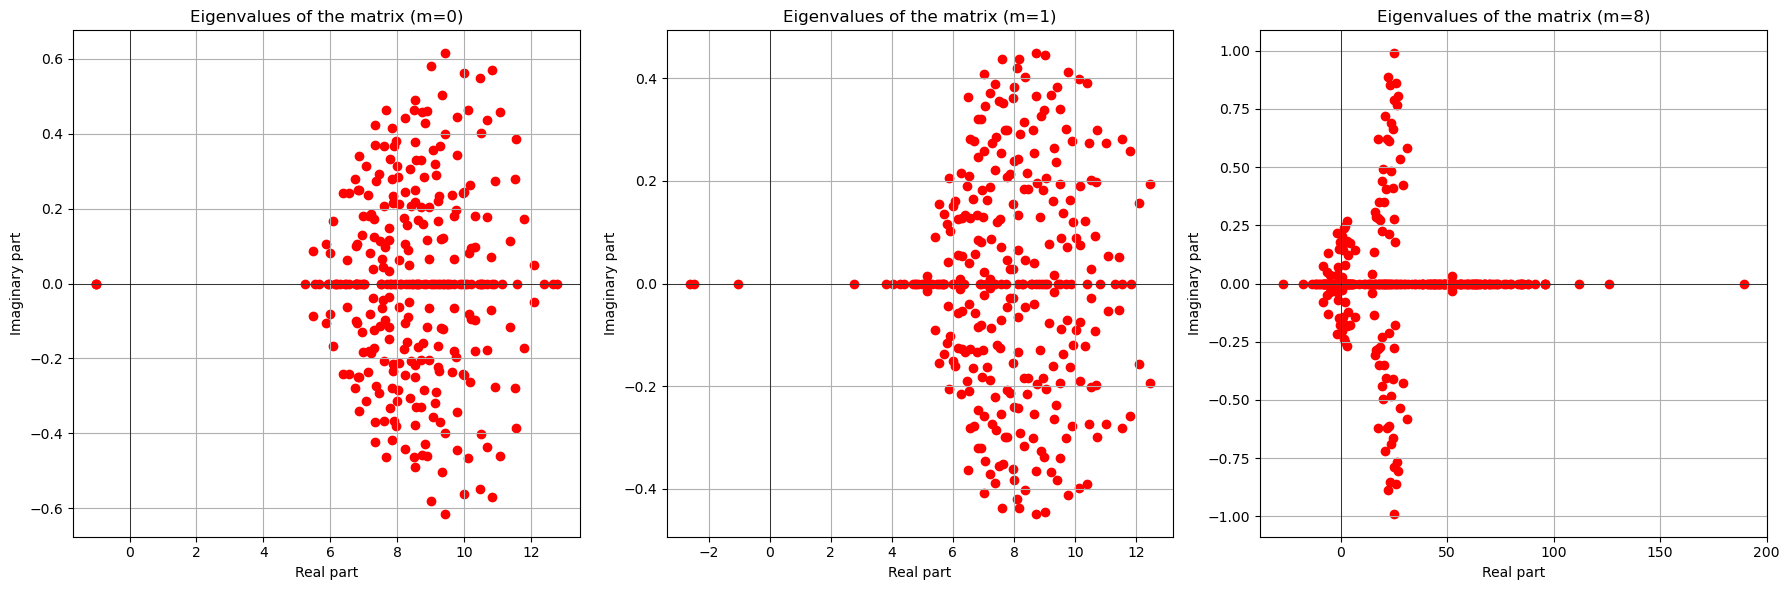

In [23]:
#Roberts way
# Parameters
L = 3
S = 100
C = 0.7
sigma = 0.02
Pc = 0
Pm = 1
Pe = 0
s = 1
matrix_para = {'S': S, 'C': C, 'sigma': sigma, 'Pm': Pm, 'Pc': Pc, 'Pe': Pe, 's': s}
r = np.ones(S * L)

# Values of m to plot
m_values = [0, 1, 8]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, m in enumerate(m_values):
    A=meta_A(L,S,matrix_para)
    m_ij=get_mij(L,S,m)

    Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)


    if A is None or m_ij is None:
        raise ValueError("A or m_ij is None. Check the implementation of meta_A and migration functions.")
    
    J=Compute_J(A,Nhatstar,m_ij)

    # Compute the eigenvalues
    eigenvalues, _ = np.linalg.eig(J)

    # Plot the eigenvalues
    axs[i].scatter(eigenvalues.real, eigenvalues.imag, color='red')
    axs[i].set_title(f'Eigenvalues of the matrix (m={m})')
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].grid(True)
    axs[i].axhline(0, color='black', linewidth=0.5)
    axs[i].axvline(0, color='black', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

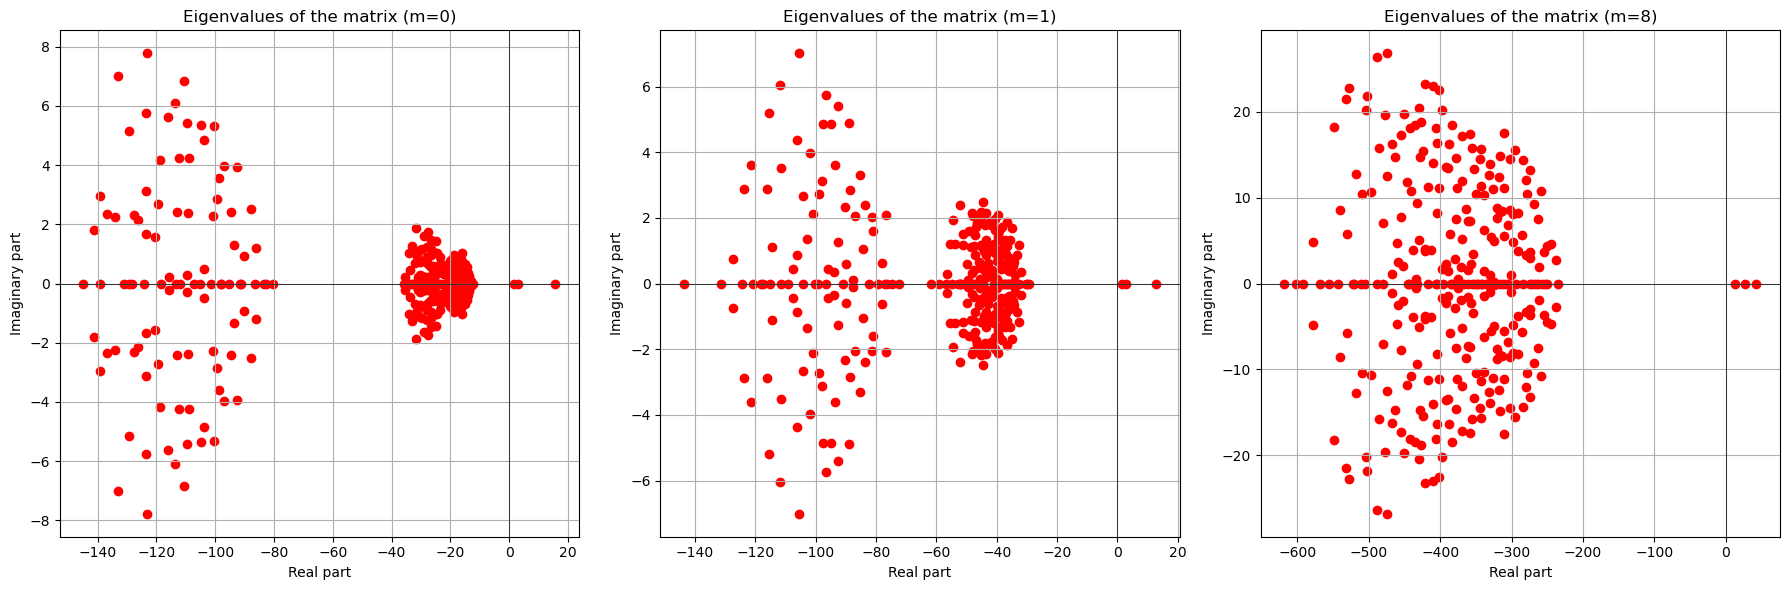

In [24]:
#Simulated GLV steady states
# Parameters
L = 3
S = 100
C = 0.7
sigma = 0.02
Pc = 0
Pm = 1
Pe = 0
s = 1
matrix_para = {'S': S, 'C': C, 'sigma': sigma, 'Pm': Pm, 'Pc': Pc, 'Pe': Pe, 's': s}
r = np.ones(S * L)

# Values of m to plot
m_values = [0, 1, 8]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, m in enumerate(m_values):
    A=meta_A(L,S,matrix_para)
    m_ij=get_mij(L,S,m)

    Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
    Nhatstar = replace_negative_values_with_ones(Nhatstar)
    Nstar = simulate_glv_system(glv_system, Nhatstar, r, A, m, m_ij, tmax=10)

    if A is None or m_ij is None:
        raise ValueError("A or m_ij is None. Check the implementation of meta_A and migration functions.")
    
    J=Compute_J(A,Nstar,m_ij)

    # Compute the eigenvalues
    eigenvalues, _ = np.linalg.eig(J)

    # Plot the eigenvalues
    axs[i].scatter(eigenvalues.real, eigenvalues.imag, color='red')
    axs[i].set_title(f'Eigenvalues of the matrix (m={m})')
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].grid(True)
    axs[i].axhline(0, color='black', linewidth=0.5)
    axs[i].axvline(0, color='black', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

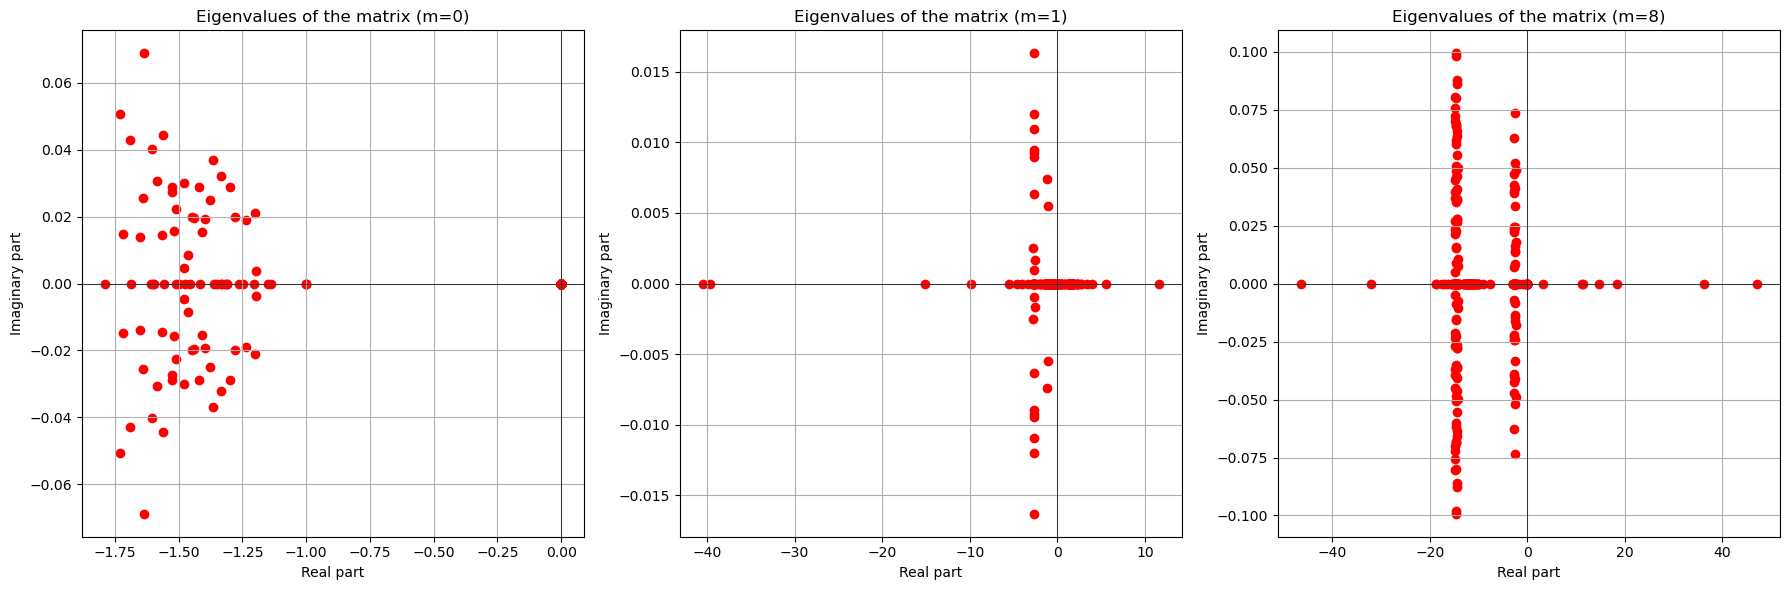

In [25]:
# F solve
# Parameters
L = 3
S = 100
C = 0.7
sigma = 0.02
Pc = 0
Pm = 1
Pe = 0
s = 1
matrix_para = {'S': S, 'C': C, 'sigma': sigma, 'Pm': Pm, 'Pc': Pc, 'Pe': Pe, 's': s}
r = np.ones(S * L)

# Values of m to plot
m_values = [0, 1, 8]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, m in enumerate(m_values):
    A=meta_A(L,S,matrix_para)
    m_ij=get_mij(L,S,m)

    Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
    Nhatstar = replace_negative_values_with_ones(Nhatstar)
    #Nstar = simulate_glv_system(glv_system, Nhatstar, r, A, m, m_ij, tmax=10)
    Nstar=steady_fsol(glv_system1, Nhatstar, r, A, m, m_ij)



    if A is None or m_ij is None:
        raise ValueError("A or m_ij is None. Check the implementation of meta_A and migration functions.")
    
    J=Compute_J(A,Nstar,m_ij)

    # Compute the eigenvalues
    eigenvalues, _ = np.linalg.eig(J)

    # Plot the eigenvalues
    axs[i].scatter(eigenvalues.real, eigenvalues.imag, color='red')
    axs[i].set_title(f'Eigenvalues of the matrix (m={m})')
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].grid(True)
    axs[i].axhline(0, color='black', linewidth=0.5)
    axs[i].axvline(0, color='black', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()


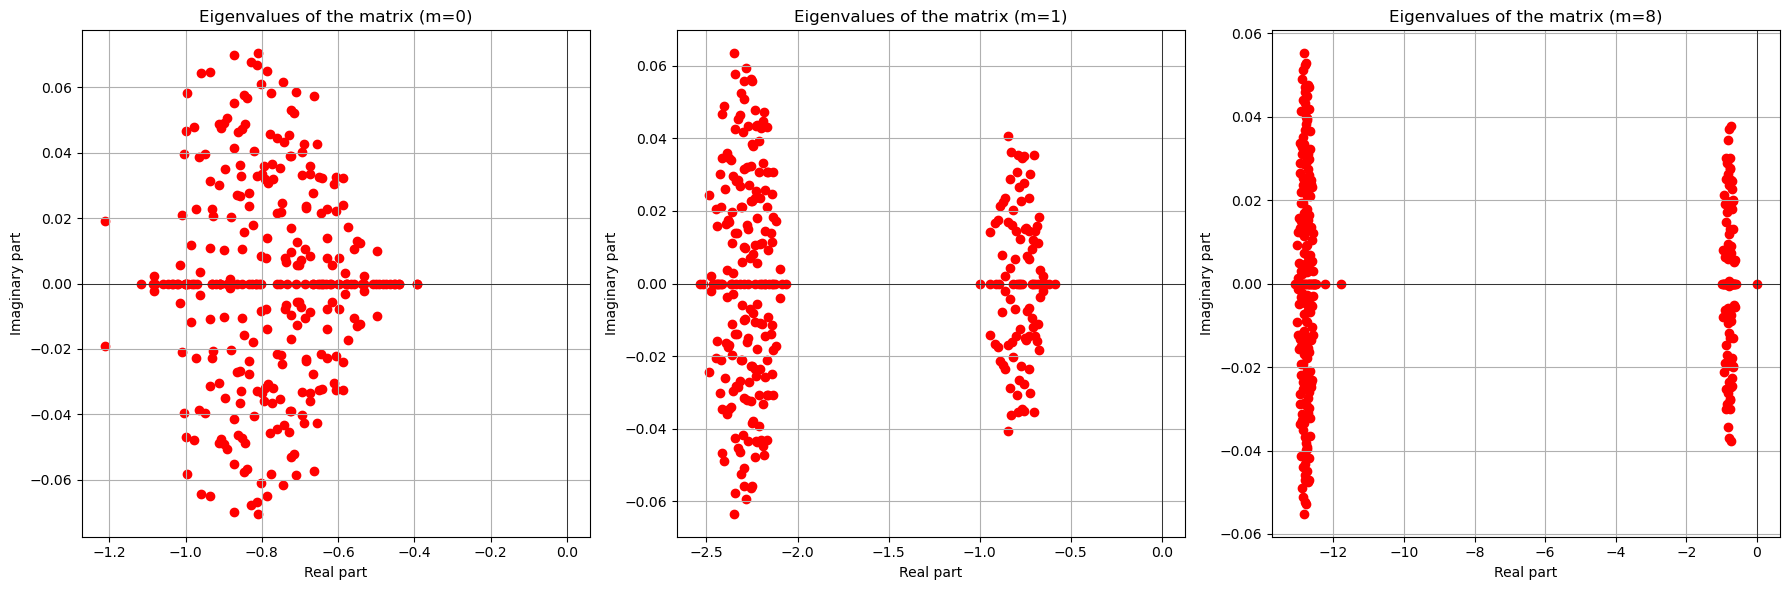

In [26]:
# With NR method
# Parameters
L = 3
S = 100
C = 0.7
sigma = 0.02
Pc = 0.5
Pm = 0.25
Pe = 0.25
s = 1
matrix_para = {'S': S, 'C': C, 'sigma': sigma, 'Pm': Pm, 'Pc': Pc, 'Pe': Pe, 's': s}
r = np.ones(S * L)

# Values of m to plot
m_values = [0, 1, 8]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, m in enumerate(m_values):
    A=meta_A(L,S,matrix_para)
    m_ij=get_mij(L,S,m)

    Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
    Nhatstar = replace_negative_values_with_ones(Nhatstar)
    #Nstar = simulate_glv_system(glv_system, Nhatstar, r, A, m, m_ij, tmax=10)
    Nstar=steady_NR(glv_system2, Nhatstar, r, A, m, m_ij)



    if A is None or m_ij is None:
        raise ValueError("A or m_ij is None. Check the implementation of meta_A and migration functions.")
    
    J=Compute_J(A,Nstar,m_ij)

    # Compute the eigenvalues
    eigenvalues, _ = np.linalg.eig(J)

    # Plot the eigenvalues
    axs[i].scatter(eigenvalues.real, eigenvalues.imag, color='red')
    axs[i].set_title(f'Eigenvalues of the matrix (m={m})')
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].grid(True)
    axs[i].axhline(0, color='black', linewidth=0.5)
    axs[i].axvline(0, color='black', linewidth=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

## Pipeline to determine feasible systems from unfeasible systems

the goal is to record the number of feasible and unfeasible systems. If we encounter feasible system ($N_i >0$), we will record the max real eigenvalues.

In [56]:
# Parameters
L=3
S=100
C=0.7
sigma= 0.02
Pc=0
Pm=1
Pe=0
s= 1

m=0
r=np.ones(S*L)

matrix_para = {'S':S, 'C':C, 'sigma':sigma, 'Pm':Pm, 'Pc':Pc, 'Pe':Pe,'s':s}

#number of repititions
n=1000

#list for feasible systems
is_feasible = []

#list for unfeasible systems
is_unfeasible = []

#record the max_real eigenvalues of Jacobian matrix of feasible systems
max_real_feasible = []

#loop to calculate to sample the feasible and unfeasible systems

for i in range(n):
    A=meta_A(L,S,matrix_para)
    m_ij=get_mij(L,S,m)

    Nhatstar=find_feasible_equilibrium(A,r,m,m_ij)
    Nhatstar = replace_negative_values_with_ones(Nhatstar)
    Nstar = steady_fsol(glv_system1, x0, r, A, m, m_ij)

    # check for values of Nstar (if values are greater than 0 is_feasible,if is less than or equal to 0 is_unfeasible)
    if np.all(Nstar > 0):
        is_feasible.append(True)
        is_unfeasible.append(False)
        J=Compute_J(A,Nstar,m_ij)
        max_real_feasible.append(max_real_eigenvalue(J))
    else:
        is_feasible.append(False)
        is_unfeasible.append(True)

#calculate the percentage of feasible systems

percentage_feasible = sum(is_feasible) / n * 100
percentage_unfeasible = sum(is_unfeasible) / n * 100

#plot percentage of feasible and unfeasible systems
plt.figure(figsize=(10, 6))
plt.bar(['Feasible', 'Unfeasible'], [percentage_feasible, percentage_unfeasible])
plt.xlabel('System Type')
plt.ylabel('Percentage')
plt.title('Percentage of Feasible and Unfeasible Systems')
plt.show()


1.5

In [76]:
import numpy as np
import plotly.graph_objects as go

# Parameters
L = 3
S = 100
C = 0.7
sigma = 0.02
s = 1
m = 0
r = np.ones(S * L)

# Define the parameter space
num_points = 20
Pm_values = np.linspace(0, 1, num_points)
Pc_values = np.linspace(0, 1, num_points)
Pe_values = np.linspace(0, 1, num_points)

n = 50

# Initialize the list to store the percentage of feasible systems
feasible_data = []

# Loop over all combinations of Pm, Pc, and Pe
for Pm in Pm_values:
    for Pc in Pc_values:
        for Pe in Pe_values:
            if np.isclose(Pm + Pc + Pe, 1):
                matrix_para = {'S': S, 'C': C, 'sigma': sigma, 'Pm': Pm, 'Pc': Pc, 'Pe': Pe, 's': s}
                is_feasible = []
                for _ in range(n):
                    A = meta_A(L, S, matrix_para)
                    m_ij = get_mij(L, S, m)
                    Nhatstar = find_feasible_equilibrium(A, r, m, m_ij)
                    Nhatstar = replace_negative_values_with_ones(Nhatstar)
                    Nstar = steady_fsol(glv_system1, Nhatstar, r, A, m, m_ij)
                    if np.all(Nstar > 0):
                        is_feasible.append(True)
                    else:
                        is_feasible.append(False)
                percentage_feasible = sum(is_feasible) / n * 100
                feasible_data.append((Pc, Pm, Pe, percentage_feasible))

# Prepare data for ternary plot
a_values, b_values, c_values, feasible_values = zip(*feasible_data)


# Create hover text
hover_text = [
    f'Pc: {a:.2f}<br>Pm: {b:.2f}<br>Pe: {c:.2f}<br>Percentage Feasible: {feasible:.2f}%'
    for a, b, c, feasible in feasible_data
]

# Plot the ternary plot
fig = go.Figure(data=[go.Scatterternary(
    a=a_values,
    b=b_values,
    c=c_values,
    mode='markers',
    marker=dict(
        size=8,
        color=feasible_values,
        colorscale='portland',
        colorbar=dict(title='Percentage Feasible'),
        showscale=True
    ),
    text=hover_text,
    hoverinfo='text'
)])

fig.update_layout(
    ternary=dict(
        sum=1,
        aaxis=dict(title='Pc'),
        baxis=dict(title='Pm'),
        caxis=dict(title='Pe')
    ),
    title='Interactive Ternary Plot of Feasible Systems',
    height=800
)

fig.show()


/var/folders/j7/3yv33mn55j95gr6wttm1nhrw0000gs/T/ipykernel_79860/347383609.py:24: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



In [78]:

# Plot the ternary plot
fig = go.Figure(data=[go.Scatterternary(
    a=a_values,
    b=b_values,
    c=c_values,
    mode='markers',
    marker=dict(
        size=15,
        color=feasible_values,
        colorscale='portland',
        colorbar=dict(title='Percentage Feasible'),
        showscale=True
    ),
    text=hover_text,
    hoverinfo='text'
)])

fig.update_layout(
    ternary=dict(
        sum=1,
        aaxis=dict(title='Pc'),
        baxis=dict(title='Pm'),
        caxis=dict(title='Pe')
    ),
    title='Interactive Ternary Plot of Feasible Systems',
    height=800
)

fig.show()


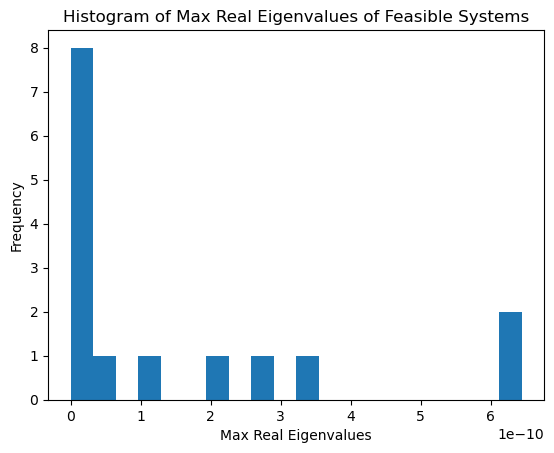

In [57]:
#plot the histogram of the max_real eigenvalues of the feasible systems
plt.hist(max_real_feasible,bins=20)
plt.xlabel('Max Real Eigenvalues')
plt.ylabel('Frequency')
plt.title('Histogram of Max Real Eigenvalues of Feasible Systems')
plt.show()